In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
sns.set_style("darkgrid")
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, SimpleRNN, LSTM, Dense, Bidirectional, Dropout, concatenate, Attention
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, jaccard_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE

In [4]:
#Loading the dataset
dataset = pd.read_excel('SWaT_Sensors_All.xlsx')

C:\ProgramData\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [5]:
class_counts = dataset['LABEL'].value_counts()

print(class_counts)

No     395419
Yes     54500
Name: LABEL, dtype: int64


In [6]:
# extract the features and target variable
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [7]:
# preprocess the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [8]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [9]:
# Split the dataset into training, testing, and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

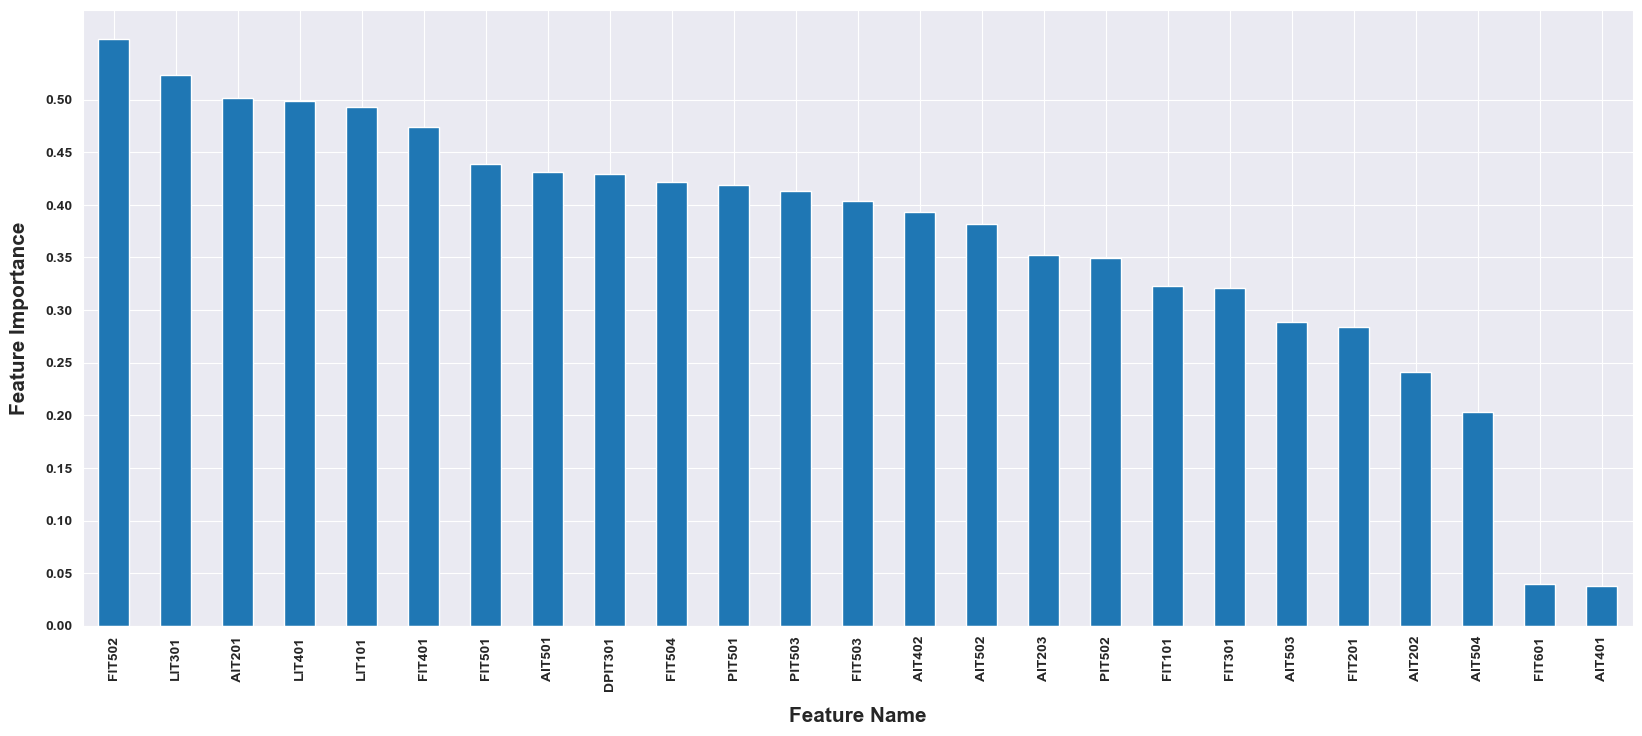

Best Threshold: 0.20731126683600842
Best Cross-Validation Score: 0.999622631106617


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Assuming X_train, y_train, X_val, X_test, and dataset are already defined

# Convert X_train to DataFrame for feature names
X_train_df = pd.DataFrame(X_train, columns=dataset.columns[:-1])

# Calculate Mutual Information
mutual_info = mutual_info_classif(X_train_df, y_train)
mutual_info = pd.Series(mutual_info, index=X_train_df.columns)

# Sort by Mutual Information
mutual_info_sorted = mutual_info.sort_values(ascending=False)

# Plot the ordered mutual_info values per feature
plt.figure(figsize=(20, 8))
mutual_info_sorted.plot.bar()
plt.xticks(weight="bold", rotation=90)
plt.yticks(np.arange(0, 0.55, 0.05), weight="bold")  # Set y-axis ticks
plt.xlabel("Feature Name", weight="bold", labelpad=12, fontsize=15)
plt.ylabel("Feature Importance", weight="bold", labelpad=12, fontsize=15)
plt.show()

# Initialize variables for cross-validation
best_threshold = 0
best_score = 0

# Perform cross-validation for different thresholds
thresholds = np.linspace(mutual_info_sorted.min(), mutual_info_sorted.max(), 50)
for threshold in thresholds:
    selected_features = mutual_info_sorted[mutual_info_sorted >= threshold].index
    X_selected = X_train_df[selected_features]

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the model
    model = DecisionTreeClassifier(random_state=42)
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_selected, y_train, cv=cv, scoring='accuracy')
    mean_score = np.mean(scores)
    
    # Update the best threshold and score
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}')
print(f'Best Cross-Validation Score: {best_score}')

# Select features based on the best threshold
final_selected_features = mutual_info_sorted[mutual_info_sorted >= best_threshold].index
X_train_selected = X_train_df[final_selected_features]
X_test_selected = pd.DataFrame(X_test, columns=dataset.columns[:-1])[final_selected_features]
X_val_selected = pd.DataFrame(X_val, columns=dataset.columns[:-1])[final_selected_features]

# Apply SparsePCA for feature reduction
spca = SparsePCA(n_components=14)
X_train = spca.fit_transform(X_train_selected)
X_val = spca.transform(X_val_selected)
X_test = spca.transform(X_test_selected)

# Reshape the data for the LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [11]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
        return weighted_sum

# Define the hybrid model
def create_hybrid_model(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # RNN branch
    rnn_branch = Dense(units=128, activation='relu')(inputs)
    rnn_branch = Dropout(0.2)(rnn_branch)
    rnn_branch = SimpleRNN(units=64, activation='relu', return_sequences=True)(rnn_branch)
    rnn_branch = Dropout(0.2)(rnn_branch)
    rnn_branch = AttentionLayer()(rnn_branch)
    rnn_branch = tf.keras.layers.Reshape((1, -1))(rnn_branch)
    rnn_branch = SimpleRNN(units=32, activation='relu', return_sequences=False)(rnn_branch)
    rnn_branch = Dropout(0.2)(rnn_branch)

    # LSTM branch
    lstm_branch = Dense(units=128, activation='relu')(inputs)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(units=64, activation='relu', return_sequences=True)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = AttentionLayer()(lstm_branch)
    lstm_branch = tf.keras.layers.Reshape((1, -1))(lstm_branch)
    lstm_branch = LSTM(units=32, activation='relu', return_sequences=False)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)

    # Bi-LSTM branch
    bi_lstm_branch = Dense(units=128, activation='relu')(inputs)
    bi_lstm_branch = Dropout(0.2)(bi_lstm_branch)
    bi_lstm_branch = Bidirectional(LSTM(units=64, activation='relu', return_sequences=True))(bi_lstm_branch)
    bi_lstm_branch = Dropout(0.2)(bi_lstm_branch)
    bi_lstm_branch = AttentionLayer()(bi_lstm_branch)
    bi_lstm_branch = tf.keras.layers.Reshape((1, -1))(bi_lstm_branch)
    bi_lstm_branch = Bidirectional(LSTM(units=32, activation='relu', return_sequences=False))(bi_lstm_branch)
    bi_lstm_branch = Dropout(0.2)(bi_lstm_branch)

    # Concatenate the outputs of the three branches
    concatenated = concatenate([rnn_branch, lstm_branch, bi_lstm_branch])

    # Output layer
    output = Dense(units=1, activation='sigmoid')(concatenated)

    # Define the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

# Create the hybrid model
input_shape = (X_train.shape[1], 1)
hybrid_model = create_hybrid_model(input_shape)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch <= 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr=0.001
for i in range (100):
    lr=scheduler(i,lr)
    print(i,lr)

callback = LearningRateScheduler(scheduler)

# Train the hybrid model
history = hybrid_model.fit(X_train, y_train, 
                           validation_data=(X_val, y_val),
                           epochs=100, batch_size=64, verbose=1, callbacks=[callback])




0 0.001
1 0.001
2 0.001
3 0.001
4 0.001
5 0.001
6 0.001
7 0.001
8 0.001
9 0.001
10 0.001
11 tf.Tensor(0.00090483745, shape=(), dtype=float32)
12 tf.Tensor(0.0008187308, shape=(), dtype=float32)
13 tf.Tensor(0.0007408183, shape=(), dtype=float32)
14 tf.Tensor(0.0006703201, shape=(), dtype=float32)
15 tf.Tensor(0.00060653075, shape=(), dtype=float32)
16 tf.Tensor(0.00054881175, shape=(), dtype=float32)
17 tf.Tensor(0.0004965854, shape=(), dtype=float32)
18 tf.Tensor(0.00044932903, shape=(), dtype=float32)
19 tf.Tensor(0.0004065697, shape=(), dtype=float32)
20 tf.Tensor(0.0003678795, shape=(), dtype=float32)
21 tf.Tensor(0.00033287113, shape=(), dtype=float32)
22 tf.Tensor(0.00030119426, shape=(), dtype=float32)
23 tf.Tensor(0.00027253185, shape=(), dtype=float32)
24 tf.Tensor(0.00024659702, shape=(), dtype=float32)
25 tf.Tensor(0.0002231302, shape=(), dtype=float32)
26 tf.Tensor(0.00020189656, shape=(), dtype=float32)
27 tf.Tensor(0.00018268357, shape=(), dtype=float32)
28 tf.Tensor(0.

KeyboardInterrupt: 

In [ ]:
# Evaluate the hybrid model
_, acc = hybrid_model.evaluate(X_test, y_test)
print("Accuracy =", (acc * 100.0), "%")

# Make predictions and evaluate metrics
y_pred = hybrid_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print classification metrics
print('Precision: %.4f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.4f' % recall_score(y_test, y_pred, average='micro'))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('F1 Score: %.4f' % f1_score(y_test, y_pred))
print('Jaccard Score: %.4f' % jaccard_score(y_test, y_pred))
print('Log Loss: %.4f' % log_loss(y_test, y_pred))
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

# Calculate Z-score
training_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]
z_score = (training_error - validation_error) / np.std(history.history['val_loss'])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score:", z_score)

# Compute ROC curve and area under curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate Z-score
training_error = history.history['loss'][-1]
testing_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]
z_score = (training_error - validation_error) / np.std(history.history['val_loss'])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score:", z_score)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Compute predictions for the test dataset
y_test_pred = hybrid_model.predict(X_test)
y_test_pred = (y_test_pred > 0.5)  # Convert predictions to binary

# Calculate Mean Squared Error for the test dataset
test_mse = mean_squared_error(y_test, y_test_pred)

# Calculate training and validation errors from history
training_error = history.history['loss'][-1]
validation_error = history.history['val_loss'][-1]

# Calculate the mean and standard deviation of training and validation errors
val_loss_std = np.std(history.history['val_loss'])
train_loss_mean = np.mean(history.history['loss'])

# Calculate Z-score for the test error
# Note: This is a relative measure, using training error and validation loss as benchmarks
z_score = (test_mse - train_loss_mean) / val_loss_std

# Print results
print("Test Mean Squared Error:", test_mse)
print("Training Error:", training_error)
print("Validation Error:", validation_error)
print("Z-Score (test error):", z_score)

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plot.bar(figsize=(20,8))
print("AUC:", roc_auc)

In [ ]:
plt.plot(history.history['loss'], label="training data")
#plt.plot(history.history['loss'], label="testing data")
plt.plot(history.history['val_loss'], label="validation data" )
#plt.plot([training_error] * len(history.history['loss']), '--')
#plt.plot([validation_error] * len(history.history['loss']), '--')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot([mse])

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test data to get the testing loss
test_loss = hybrid_model.evaluate(X_test, y_test)[0]

# Plot training loss
plt.plot(history.history['loss'], label="training data")

# Plot testing loss
plt.plot([test_loss] * len(history.history['loss']), label="testing data", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss= history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, acc,'y', label='training data')
plt.plot(epochs,val_acc,'g', label='validation data')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']
#epochs=range(1, len(loss)+1)
plt.plot(epochs,acc,'y', label='training accuracy')
plt.plot(epochs,val_acc,'g', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:

# Predict probabilities for both models
pred = hybrid_model.predict(X_test)

In [ ]:
# Compute ROC curve and area under curve (AUC) for both models
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr, label='RNN (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']  # Training accuracy
test_acc = history.history['val_accuracy']  # Testing accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, test_acc, 'g', label='Testing accuracy')

plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract training loss from history
train_loss = history.history['loss']

# Evaluate the model on the test data to get the testing loss
test_loss, _ = hybrid_model.evaluate(X_test, y_test)

# Print training and testing loss
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Testing Loss: {test_loss}")

# Create an array of epochs for plotting
epochs = range(1, len(train_loss) + 1)

# Plot training loss
plt.plot(epochs, train_loss, 'orange', label='Training Loss')

# Plot testing loss
plt.plot(epochs, [test_loss] * len(epochs), 'green', label='Testing Loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()